<a href="https://colab.research.google.com/github/Cams75018/Velib_predictions/blob/master/LSTM_multistep_min_par_min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf

### **Parametres**

In [0]:
import timeit
start_time = timeit.default_timer()

In [0]:
heurefin=9   # heure de test de la journée et donc cut du dataset au dernier jour à cette heure
nsteps_in, nsteps_out = 90, 30
epok =5

In [4]:

df=pd.read_csv("https://raw.githubusercontent.com/alexisgcomte/velib-prediction/master/3.%20Modeling%20Research/datasets/madeleine_weekday.csv")
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (14800, 5)


,Unnamed: 0,availiable_docks,date,weekday,hour
0,0,8,2020-01-15 10:17:00,Wednesday,10
1,1,8,2020-01-15 10:18:00,Wednesday,10
2,2,7,2020-01-15 10:19:00,Wednesday,10
3,3,8,2020-01-15 10:20:00,Wednesday,10
4,4,8,2020-01-15 10:21:00,Wednesday,10


In [5]:
for ind in range(len(df)-1, -int(len(df)/10)  , -1):
   if df.hour[ind]==heurefin:
     print(df.date[ind],ind, len(df))
     findf=ind
     break

2020-01-29 09:59:00 13939 14800


In [6]:
df2=df.loc[:findf,['date','availiable_docks']]
#df3.sort_values('datenew', inplace=True, ascending=True)
#df3 = df3.reset_index(drop=True)
print('Number of rows and columns:',df2.shape)
print(df2.date.min())
print(df2.date.max())
df2.columns=["datenew","TOTALFD"]
df2.tail(5)

Number of rows and columns: (13940, 2)
2020-01-15 10:17:00
2020-01-29 09:59:00


,datenew,TOTALFD
13935,2020-01-29 09:55:00,0
13936,2020-01-29 09:56:00,0
13937,2020-01-29 09:57:00,0
13938,2020-01-29 09:58:00,0
13939,2020-01-29 09:59:00,0


In [7]:
df3=df2.loc[:len(df2)-1-nsteps_out,["datenew","TOTALFD"]]
df3.tail()

,datenew,TOTALFD
13905,2020-01-29 09:25:00,0
13906,2020-01-29 09:26:00,0
13907,2020-01-29 09:27:00,0
13908,2020-01-29 09:28:00,0
13909,2020-01-29 09:29:00,0


In [8]:
print('Number of rows and columns after removing missing values:', df3.shape)
print('The time series starts from: ', df3.datenew.min())
print('The time series ends on: ', df3.datenew.max())

Number of rows and columns after removing missing values: (13910, 2)
The time series starts from:  2020-01-15 10:17:00
The time series ends on:  2020-01-29 09:29:00


### First Time series plot

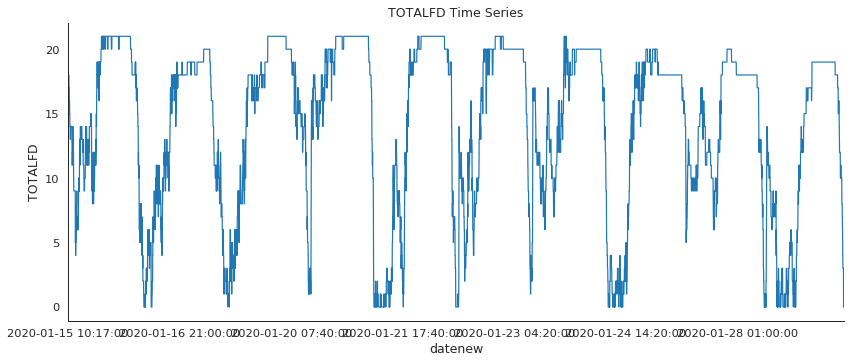

In [9]:
df4=df3.loc[:,['datenew','TOTALFD']]
df5=df3.loc[:,['datenew','TOTALFD']]
df4.set_index('datenew',inplace=True)
df4.plot(figsize=(12,5))
plt.ylabel('TOTALFD')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('TOTALFD Time Series')
sns.despine(top=True)
plt.show();

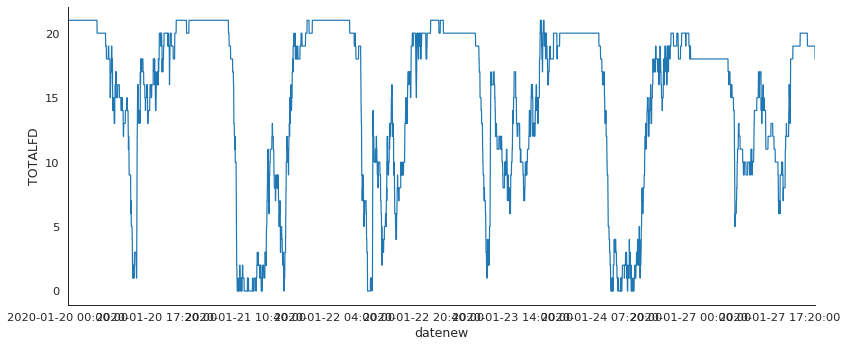

In [10]:
df5=df4[(df4.index>='2020-01-20') & (df4.index<'2020-01-28')]
df5.plot(figsize=(12,5));
plt.ylabel('TOTALFD')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

### TOTALFD Distribution

,count,mean,std,min,25%,50%,75%,max
TOTALFD,13910.0000,14.3774,6.4634,0.0000,10.0000,17.0000,20.0000,21.0000


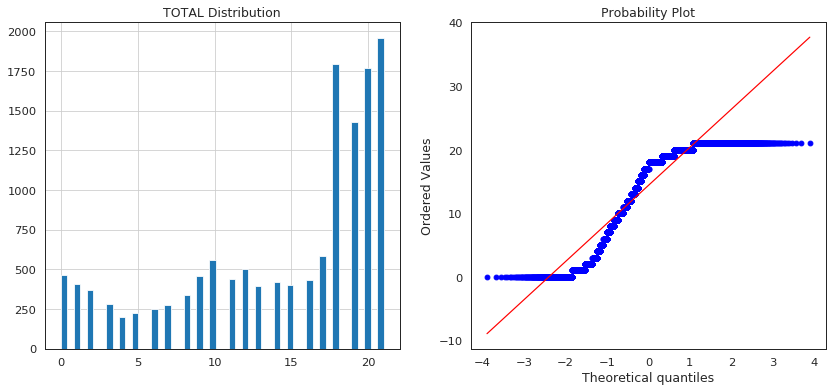

In [11]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df3['TOTALFD'].hist(bins=50)
plt.title('TOTAL Distribution')

plt.subplot(1,2,2)
stats.probplot(df3['TOTALFD'], plot=plt);
df3.describe().T

Normal probability plot also shows the data set is far from normally distributed.

**MULTI-STEP LSTM**

In [0]:
from sklearn.preprocessing import MinMaxScaler

LSTM multi-step encoder -decoder step_in 96, setp out 5 couche 100  normalisé

In [13]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
  # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
raw_seq = df3.TOTALFD.to_numpy()
#normalisation
raw_seq_scaled = scaler.fit_transform(raw_seq.reshape(-1,1))
#raw_seq_scaled = scaled_values.reshape(1,len(raw_seq_scaled)  )
# choose a number of time steps

n_steps_in, n_steps_out = nsteps_in, nsteps_out

X, y = split_sequence(raw_seq_scaled, n_steps_in, n_steps_out)
X=X.reshape(X.shape[0],X.shape[1])
y= y.reshape(y.shape[0],y.shape[1])
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
#model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=epok) # verbose=0)
# demonstrate prediction
#x_input = array(raw_seq[-n_steps_in:])
# Normalisation du "Test"
X_input_scal=scaler.transform(array(raw_seq[-n_steps_in:]).reshape(-1,1))
X_input_scal.reshape(X_input_scal.shape[0],)
X_input_scal = X_input_scal.reshape((1, n_steps_in, n_features))
#x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(X_input_scal, verbose=0)
yhat=scaler.inverse_transform(yhat.reshape(yhat.shape[0],yhat.shape[1]))
elapsed = timeit.default_timer() - start_time
print(yhat)

Using TensorFlow backend.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





13791/13791 [==============================] - 90s 7ms/step - loss: 0.0480
Epoch 2/5
13791/13791 [==============================] - 80s 6ms/step - loss: 0.0297
Epoch 3/5
13791/13791 [==============================] - 81s 6ms/step - loss: 0.0291
Epoch 4/5
13791/13791 [==============================] - 82s 6ms/step - loss: 0.0284
Epoch 5/5
13791/13791 [==============================] - 81s 6ms/step - loss: 0.0282
[[-0.42705417 -0.02646965 -0.01246566 -0.01240307  0.03201091  0.10950851
   0.20055073  0.2974584   0.38885486  0.47126913  0.55881536  0.64823663
   0.7353022   0.8161669   0.8898243   0.9524542   1.0056126   1.0511494
   1.090186    1.1236951   1.1525142   1.1773642   1.1988609   1.2175262
   1.2338083   1.2480751   1.2606385   1.2717597   1.281647    1.2904863 ]]


**Visualisation predictions**

In [14]:


dfres=df2.tail(n_steps_out*3)
dfres["pred"]=0.0
dfres = dfres.reset_index()
#lastindex=dfres.tail(1).index.start
yhat2=pd.DataFrame(yhat.reshape(n_steps_out,1))
for ind in range(len(dfres)-1, -len(yhat2) + len(dfres)-1 , -1):
   dfres["pred"][ind]=yhat2.iloc[ind-len(dfres)]
dfres.tail(n_steps_out)



,index,datenew,TOTALFD,pred
60,13910,2020-01-29 09:30:00,1,-0.4271
61,13911,2020-01-29 09:31:00,1,-0.0265
62,13912,2020-01-29 09:32:00,0,-0.0125
63,13913,2020-01-29 09:33:00,0,-0.0124
64,13914,2020-01-29 09:34:00,0,0.0320
65,13915,2020-01-29 09:35:00,0,0.1095
66,13916,2020-01-29 09:36:00,0,0.2006
67,13917,2020-01-29 09:37:00,0,0.2975
68,13918,2020-01-29 09:38:00,0,0.3889
69,13919,2020-01-29 09:39:00,0,0.4713


In [15]:
from math import sqrt
from sklearn.metrics import mean_squared_error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
msedf=dfres.tail(n_steps_out)

print("RMSE ",measure_rmse(msedf.TOTALFD,msedf.pred))
print("RMSE prédictions arrondies ", measure_rmse(msedf.TOTALFD,round(msedf.pred)))
print("nb epoch", epok)
print("nb stepIN", nsteps_in)
print("nb stepOUT", nsteps_out)
print("Tranche horaire entre ",heurefin,"h",nsteps_out," et " ,heurefin,"h",nsteps_out," + ", nsteps_out, " min")
print("temps d'execution " , int(elapsed/60), "min", int((round(elapsed/60,2,)-(int(elapsed/60)))*60), "s")

RMSE  0.9057583004270776
RMSE prédictions arrondies  0.816496580927726
nb epoch 5
nb stepIN 90
nb stepOUT 30
Tranche horaire entre  9 h 30  et  9 h 30  +  30  min
temps d'execution  6 min 58 s


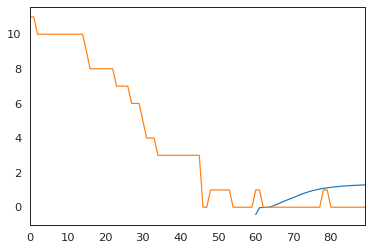

In [16]:

import matplotlib.pyplot as plt
dfres['pred'].tail(n_steps_out).plot()
dfres['TOTALFD'].plot()


# code you want to evaluate
elapsed = timeit.default_timer() - start_time
